# 텐서플로우 설치와 기초

In [34]:
import tensorflow as tf

print(tf.__version__)

1.10.0


In [35]:
x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x*x*y + y +2

In [36]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
result

42

In [37]:
sess.close()

In [38]:
# 위 셀과 동일
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
result

42

In [39]:
#InteractiveSession : 자동으로 적용. 수동으로 종료해줘야함
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
result = f.eval()
result

42

In [40]:
sess.close()

In [41]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()
# 노드 생성하면 자동으로 기본 그래프에 추가됨

True

In [42]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [43]:
x2.graph is tf.get_default_graph() #이렇게 그래프 따로 만드는 것도 가능

False

In [44]:
tf.reset_default_graph() # 기본 그래프 초기화. 동일한 명령 많이 실행하면 그래프에 중복된 노드 많이 포함되기 때문. 특히 주피터 노트북

In [45]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())
# w,x 두 번 eval()

print('-'*30)

with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)
# 한 번씩만 eval()

10
15
------------------------------
10
15


In [46]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

housing_data_plus_bias

array([[   1.        ,    8.3252    ,   41.        , ...,    2.55555556,
          37.88      , -122.23      ],
       [   1.        ,    8.3014    ,   21.        , ...,    2.10984183,
          37.86      , -122.22      ],
       [   1.        ,    7.2574    ,   52.        , ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.        ,    1.7       ,   17.        , ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.        ,    1.8672    ,   18.        , ...,    2.12320917,
          39.43      , -121.32      ],
       [   1.        ,    2.3886    ,   16.        , ...,    2.61698113,
          39.37      , -121.24      ]])

In [47]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

theta_value

array([[-3.7185181e+01],
       [ 4.3633747e-01],
       [ 9.3952324e-03],
       [-1.0711310e-01],
       [ 6.4479220e-01],
       [-4.0337982e-06],
       [-3.7813708e-03],
       [-4.2348409e-01],
       [-4.3721911e-01]], dtype=float32)

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m,1)), scaled_housing_data]

In [49]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01


X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0,), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
#gradients = 2/m * tf.matmul(tf.transpose(X), error)
#gradients = tf.gradients(mse, [theta])[0]  #자동 미분

#training_op = tf.assign(theta, theta - learning_rate * gradients)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        if epoch%100 == 0:
            print("Epoch:", epoch, "MSE =", mse.eval())
        sess.run(training_op)

    best_theta = theta.eval()

best_theta

Epoch: 0 MSE = 6.4298997
Epoch: 100 MSE = 0.8760676
Epoch: 200 MSE = 0.7161416
Epoch: 300 MSE = 0.6653869
Epoch: 400 MSE = 0.6295284
Epoch: 500 MSE = 0.60312605
Epoch: 600 MSE = 0.5835972
Epoch: 700 MSE = 0.56910485
Epoch: 800 MSE = 0.55831355
Epoch: 900 MSE = 0.5502479


array([[ 2.0685525 ],
       [ 0.8730972 ],
       [ 0.16832289],
       [-0.27020127],
       [ 0.27549165],
       [ 0.01296562],
       [-0.04444658],
       [-0.49769455],
       [-0.4696624 ]], dtype=float32)

In [50]:
# 미니 배치

tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0,), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
#gradients = 2/m * tf.matmul(tf.transpose(X), error)
#gradients = tf.gradients(mse, [theta])[0]  #자동 미분

#training_op = tf.assign(theta, theta - learning_rate * gradients)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            _, e = sess.run([training_op, mse], feed_dict={X: X_batch, y: y_batch})
        if epoch%100 == 0:
            print("Epoch:", epoch, "MSE =", e)

    best_theta = theta.eval()

best_theta

Epoch: 0 MSE = 0.481489
Epoch: 100 MSE = 0.5991949
Epoch: 200 MSE = 0.51553625
Epoch: 300 MSE = 0.5868294
Epoch: 400 MSE = 0.41824028
Epoch: 500 MSE = 0.4198235
Epoch: 600 MSE = 0.3623761
Epoch: 700 MSE = 0.49003166
Epoch: 800 MSE = 0.70626646
Epoch: 900 MSE = 0.68236345


array([[ 2.0714476 ],
       [ 0.8462012 ],
       [ 0.11558535],
       [-0.26835832],
       [ 0.32982782],
       [ 0.00608358],
       [ 0.07052915],
       [-0.87988573],
       [-0.8634251 ]], dtype=float32)

# tensor board로 시각화

In [51]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0,), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
#gradients = 2/m * tf.matmul(tf.transpose(X), error)
#gradients = tf.gradients(mse, [theta])[0]  #자동 미분

#training_op = tf.assign(theta, theta - learning_rate * gradients)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        if epoch%100 == 0:
            save_path = saver.save(sess, "tmp/my_model_final.ckpt")
            best_theta = theta.eval()

file_writer.close()
best_theta

array([[ 2.0797708e+00],
       [ 8.3361232e-01],
       [ 1.3316789e-01],
       [-2.5319967e-01],
       [ 3.5697648e-01],
       [ 5.4392917e-04],
       [-1.4757084e-02],
       [-9.1245729e-01],
       [-8.7146127e-01]], dtype=float32)

# 연습문제 12

In [52]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51020 missing from curre

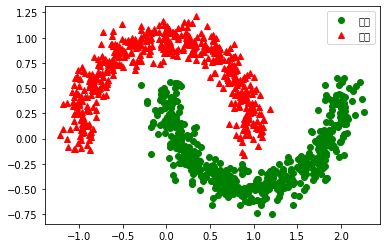

In [54]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="양성")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="음성")
plt.legend()
plt.show()

In [55]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
X_moons_with_bias = np.c_[X_moons_with_bias, np.square(X_moons_with_bias[:,1]), np.square(X_moons_with_bias[:,2]),X_moons_with_bias[:,1] ** 3, X_moons_with_bias[:,2] ** 3]

In [56]:
y_moons_column = y_moons.reshape(-1,1)

In [57]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column[:-test_size]
y_test = y_moons_column[-test_size:]
X_test.shape

(200, 7)

In [58]:
def random_bach(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [59]:
n_inputs = 6
learning_rate = 0.01
n_epochs = 1000
batch_size= 50
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)

loss = tf.losses.log_loss(y, y_proba)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_bach(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch%100 == 0:
            print("Epoch:",epoch, "Loss", loss_val)
        
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 Loss 0.95792145
Epoch: 100 Loss 0.2749585
Epoch: 200 Loss 0.22142723
Epoch: 300 Loss 0.19295411
Epoch: 400 Loss 0.1738237
Epoch: 500 Loss 0.15967526
Epoch: 600 Loss 0.14834434
Epoch: 700 Loss 0.13893403
Epoch: 800 Loss 0.13103245
Epoch: 900 Loss 0.12415364


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51020 missing from curre

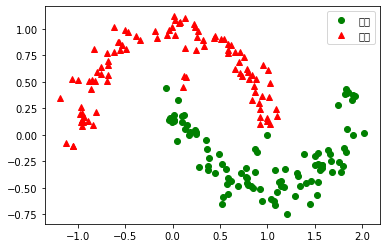

In [60]:
y_pred = (y_proba_val >= 0.5)
y_pred_idx = y_pred.reshape(-1)
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="양성")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="음성")
plt.legend()
plt.show()

In [61]:
def logistic_regression(X, y, initializer=None, learning_rate=0.01):
    n_inputs = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs, 1], -1, 1)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
            
    return y_proba, loss, training_op, loss_summary, init, saver
        

In [62]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return"{}/{}/".format(root_logdir, name)

In [63]:
n_inputs = 6
logdir = log_dir("CH09")

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [64]:
import os

In [65]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "tmp/09. my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "models/09. my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        #체크포인트 파일 있는 경우
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 이어서 훈련합니다.", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_bach(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch%500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch+1))
                
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.6911264
Epoch: 500 	Loss: 0.18055119
Epoch: 1000 	Loss: 0.12992948
Epoch: 1500 	Loss: 0.10477211
Epoch: 2000 	Loss: 0.089270264
Epoch: 2500 	Loss: 0.07884099
Epoch: 3000 	Loss: 0.071235985
Epoch: 3500 	Loss: 0.06547121
Epoch: 4000 	Loss: 0.06088248
Epoch: 4500 	Loss: 0.057164956
Epoch: 5000 	Loss: 0.05407447
Epoch: 5500 	Loss: 0.051474743
Epoch: 6000 	Loss: 0.049234513
Epoch: 6500 	Loss: 0.047287054
Epoch: 7000 	Loss: 0.045575052
Epoch: 7500 	Loss: 0.044051714
Epoch: 8000 	Loss: 0.042696334
Epoch: 8500 	Loss: 0.041474234
Epoch: 9000 	Loss: 0.04036244
Epoch: 9500 	Loss: 0.039343886
Epoch: 10000 	Loss: 0.038461264


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51020 missing from curre

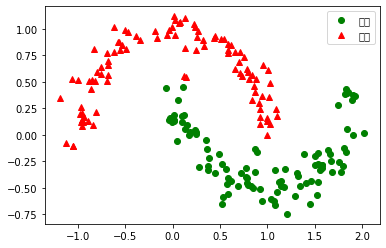

In [66]:
y_pred = (y_proba_val >= 0.5)
y_pred_idx = y_pred.reshape(-1)
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="양성")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="음성")
plt.legend()
plt.show()

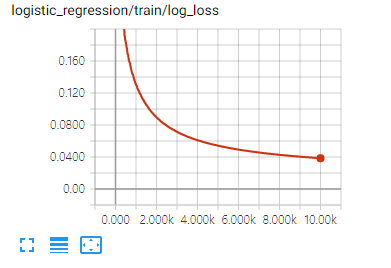